In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from pysal.lib import weights
from libpysal.io import open as psopen
# import plots
import seaborn as sns
from datetime import datetime, timedelta
import jenkspy
import warnings
warnings.filterwarnings("ignore")


In [2]:
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/research/RECAST/latin-mobility-covid-local-files'

country = 'Colombia'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
elif country == 'Mexico':
    country_short = 'MEX'
    country_code = 'MX'

In [3]:
def compute_flows(df_mov_evo, flow_type):

    if flow_type == 'outflows':
        df_flows = pd.DataFrame({'O': np.unique(df_mov_evo['O'])})
    elif flow_type == 'inflows':
        df_flows = pd.DataFrame({'D': np.unique(df_mov_evo['D'])})
        
    df_flows_add = pd.DataFrame({column: [np.nan for i in range(len(df_flows))] for column in df_mov_evo.columns[2:]})

    df_flows = pd.concat([df_flows, df_flows_add], axis=1)   

    for i in range(len(df_flows)):
        if flow_type == 'outflows':
            ID = df_flows.loc[i,'O']
            df = df_mov_evo[df_mov_evo['O']==ID]
        elif flow_type == 'inflows':
            ID = df_flows.loc[i,'D']
            df = df_mov_evo[df_mov_evo['D']==ID]
        
        for column in df_flows.columns[1:]:
            to_sum = []
            for x in df[column]:
                if pd.isna(x) == False:
                    to_sum.append(x)
            if len(to_sum) == 0:
                df_flows.loc[i, column] = np.nan
            else:
                flow = np.sum(df[column])
                df_flows.loc[i, column] = flow
        
    return df_flows

In [4]:
def compute_df_ts(df_flows, df_flows_baseline, initial_col):

    evo_movs = []
    evo_movs_baseline = []
    for column in df_flows.columns[initial_col:]:
        sum_evo_movs = []
        sum_evo_movs_baseline = []
        for i in range(0,len(df_flows)):
            if pd.isna(df_flows.loc[i, column]) == False and pd.isna(df_flows_baseline.loc[i, column]) == False:
                sum_evo_movs.append(df_flows.loc[i, column])
                sum_evo_movs_baseline.append(df_flows_baseline.loc[i, column])
        if len(sum_evo_movs) > 0:
            evo_movs.append(np.sum(sum_evo_movs))
            evo_movs_baseline.append(np.sum(sum_evo_movs_baseline))
        else:
            evo_movs.append(np.nan)
            evo_movs_baseline.append(np.nan)

    df_ts = pd.DataFrame({'date': df_flows.columns[initial_col:], 'movements': evo_movs, 'baseline': evo_movs_baseline})

    # Replace zeros and infs by NaNs, then replace NaNs by average of closest 15 observations in time series
    for i in range(len(df_ts)):
        if df_ts.loc[i, 'movements'] == 0:
            df_ts.loc[i, 'movements'] = np.nan
    df_ts.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_ts['isna'] = df_ts['movements'].isna()
    df_ts['movements_fill'] = df_ts['movements']
    df_ts_dropna = df_ts.dropna()
    df_ts_dropna
    indexes = df_ts[df_ts['isna']==True].index
    for target_index in indexes:
        # Calculate the absolute difference between the row indices and the target index
        df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
        # Sort the DataFrame by this difference
        df_sorted = df_ts_dropna.sort_values(by='diff')
        # Select the top 15 rows
        nearest_rows = df_sorted.head(15)
        # Drop the 'diff' column if you don't need it anymore
        df_ts.loc[target_index, 'movements_fill'] = np.mean(nearest_rows['movements'])
        df_ts_dropna.drop(columns=['diff'])
    df_ts.loc[:,'rolling'] = df_ts['movements_fill'].rolling(window=15).mean()


    # Replace zeros by NaNs, then replace NaNs by average of closest 15 observations in time series
    for i in range(len(df_ts)):
        if df_ts.loc[i, 'baseline'] == 0:
            df_ts.loc[i, 'baseline'] = np.nan
    df_ts['isna'] = df_ts['baseline'].isna()
    df_ts['baseline_fill'] = df_ts['baseline']
    df_ts_dropna = df_ts.dropna()
    df_ts_dropna
    indexes = df_ts[df_ts['isna']==True].index
    for target_index in indexes:
        # Calculate the absolute difference between the row indices and the target index
        df_ts_dropna.loc[:,'diff'] = list(abs(df_ts_dropna.index - target_index))
        # Sort the DataFrame by this difference
        df_sorted = df_ts_dropna.sort_values(by='diff')
        # Select the top 15 rows
        nearest_rows = df_sorted.head(15)
        # Drop the 'diff' column if you don't need it anymore
        df_ts.loc[target_index, 'baseline_fill'] = np.mean(nearest_rows['baseline'])
        df_ts_dropna.drop(columns=['diff'])
    df_ts.loc[:,'rolling_baseline'] = df_ts['baseline_fill'].rolling(window=15).mean()
    
    df_ts['perchange'] = [(df_ts.loc[i,'movements_fill']-df_ts.loc[i,'baseline_fill'])/df_ts.loc[i,'baseline_fill']*100 for i in range(len(df_ts))]
    df_ts.loc[:,'rolling_perchange'] = df_ts['perchange'].rolling(window=30).mean()

    return df_ts

In [5]:
def compute_df_ts_weekly(df_ts):
    
    df_ts_weekly = pd.DataFrame({'week_no': range(int(len(df_ts)/7))})
    df_ts_weekly['week_start'] = [df_ts.loc[i*7, 'date'] for i in range(int(len(df_ts)/7))]
    df_ts_weekly['movements'] = [np.sum(df_ts.loc[i*7:(i+1)*7-1, 'movements']) for i in range(int(len(df_ts)/7))]
    df_ts_weekly['baseline'] = [np.sum(df_ts.loc[i*7:(i+1)*7-1, 'baseline']) for i in range(int(len(df_ts)/7))]
    df_ts_weekly['movements_fill'] = [np.sum(df_ts.loc[i*7:(i+1)*7-1, 'movements_fill']) for i in range(int(len(df_ts)/7))]
    df_ts_weekly['baseline_fill'] = [np.sum(df_ts.loc[i*7:(i+1)*7-1, 'baseline_fill']) for i in range(int(len(df_ts)/7))]
    df_ts_weekly['perchange'] = [(df_ts_weekly.loc[i,'movements_fill']-df_ts_weekly.loc[i,'baseline_fill'])/df_ts_weekly.loc[i,'baseline_fill']*100 for i in range(len(df_ts_weekly))]

    return df_ts_weekly

In [6]:
df_stringency = pd.read_csv(wd + '/data/inputs/covid-stringency/owid-covid-data.csv')
df_stringency = df_stringency[df_stringency['location'] == str(country).capitalize()].reset_index(drop=True)                     
                                      

In [7]:
baseline_pop_imput = gpd.read_file(wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop-with-exo-var/movcell-baseline-imput-pop-with-exo-var.gpkg')




### Evolution by day or by week, distance >= 0 or > 0, data raw or processed

In [8]:
dist = True
raw = False
adjust = True

if dist == True:
    dist = '_dist'
else:
    dist = ''
if raw == True:
    raw = '_raw'
else:
    raw = '' 
    if adjust == True:
        adjust = '_adjust'
    else:
        adjust = ''
    

In [9]:
df_mov_evo = pd.read_csv(wd + '/data/outputs/' + country_short + '/evo/mov_evo' + dist + raw + adjust + '.csv').drop('Unnamed: 0', axis=1)
df_mov_evo_baseline = pd.read_csv(wd + '/data/outputs/' + country_short + '/evo/mov_evo_baseline' + dist + raw + '.csv').drop('Unnamed: 0', axis=1)



In [10]:
#Only uncomment when wanting to run the code (takes a while)

# df_outflows = compute_flows(df_mov_evo, 'outflows')
# df_inflows = compute_flows(df_mov_evo, 'inflows')
# df_outflows_baseline = compute_flows(df_mov_evo_baseline, 'outflows')
# df_inflows_baseline = compute_flows(df_mov_evo_baseline, 'inflows')
# df_outflows.to_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/outflows' + dist + raw + adjust + '_sample.csv')
# df_inflows.to_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/inflows' + dist + raw + adjust + '_sample.csv')
# df_outflows_baseline.to_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/outflows_baseline'+ dist + raw  + '_sample.csv')
# df_inflows_baseline.to_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/inflows_baseline' + dist + raw + '_sample.csv')


In [11]:
flows = 'outflows' # change to movs, inflows or outflows

if flows == 'inflows' or flows == 'outflows':
    df_flows = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/' + flows + dist + raw + adjust + '.csv').drop('Unnamed: 0', axis=1)
    df_flows_baseline = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/' + flows + '_baseline' + dist + raw + '.csv').drop('Unnamed: 0', axis=1)
    initial_col = 1
else:
    df_flows = df_mov_evo
    df_flows_baseline = df_mov_evo_baseline
    initial_col = 2

In [12]:
df_ts = compute_df_ts(df_flows, df_flows_baseline, initial_col)


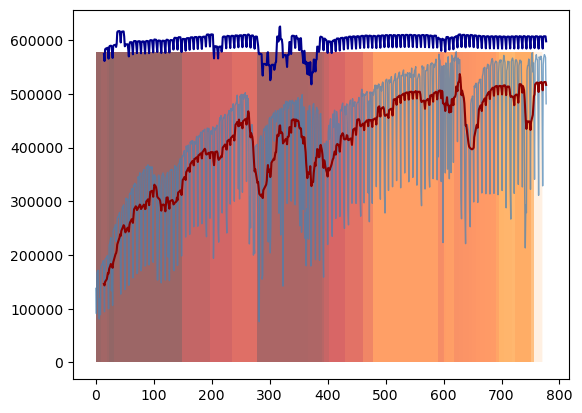

In [13]:
fig, ax = plt.subplots()

# ax.set_ylim([-2000, 45000])

ax.plot(np.arange(len(df_ts)), df_ts['movements_fill'], color='steelblue', lw=1, alpha=0.7)
ax.plot(np.arange(len(df_ts)), df_ts['rolling'], color='darkred', lw=1.5)
ax.plot(np.arange(len(df_ts)), df_ts['rolling_baseline'], color='darkblue', lw=1.5)

stringencies = []
for date in df_ts['date']:
    stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

for k in range(len(df_ts)):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, 0, max(df_ts['movements_fill'])*np.ones(len(x)), color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)


plt.show()

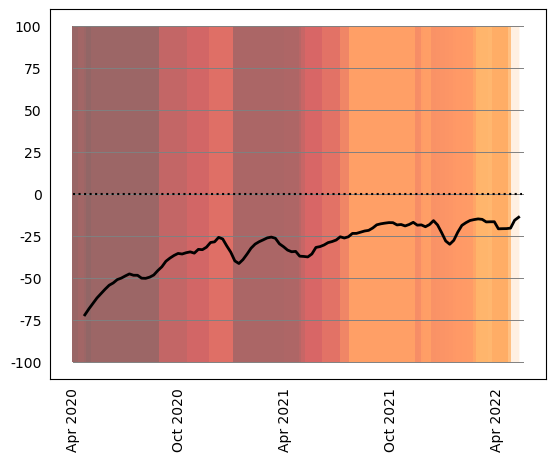

In [14]:
fig, ax = plt.subplots()

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

df_ts_weekly = compute_df_ts_weekly(df_ts)

df_ts_weekly.loc[:,'rolling_perchange'] = df_ts_weekly['perchange'].rolling(window=4).mean()
# ax.plot(np.arange(len(df_ts['rolling_perchange'])), df_ts['rolling_perchange'], color='gold', lw=2, zorder=3)
ax.plot(np.arange(len(df_ts_weekly['rolling_perchange']))*7, df_ts_weekly['rolling_perchange'], color='black', lw=2, zorder=3)
# ax.plot(np.arange(len(df_ts_weekly['perchange']))*7, df_ts_weekly['perchange'], color='darkred', lw=2, zorder=2)
# ax.plot(np.arange(len(df_ts['perchange'])), df_ts['perchange'], lw=.5, zorder=1)
ax.plot(np.arange(len(df_ts_weekly['rolling_perchange'])*7), np.zeros(len(df_ts_weekly['rolling_perchange'])*7), linestyle=':', color='k')

stringencies = []
for date in df_ts['date']:
    stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

ymin = int(min([-100, np.min(df_ts_weekly['rolling_perchange'])]))
ymax = int(max([101, np.max(df_ts_weekly['rolling_perchange'])+1]))

for k in range(len(df_ts)):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, -100, 100, color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)

xticks = []
xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
for i in range(0, len(df_ts['rolling_perchange'])):
    if i%183 == 0:
        xticks.append(i)
ax.set_xticks(xticks, xticks_labels)
ax.tick_params(axis = 'x', bottom=True, labelsize = 10, pad=6, rotation=90)
    
yticks = []
for i in range(ymin, ymax):
    if i%25 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([0, len(df_ts['rolling_perchange'])],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 10, pad=6, rotation=0)
    
# plt.savefig(wd + '/plots/evolution/' + flows + '/total/' + country_short + '/evo' + dist + raw + adjust + '.pdf', bbox_inches = 'tight')

plt.show()

### By density class

In [15]:
n_class_density = 5

breaks_density = jenkspy.jenks_breaks(baseline_pop_imput.dropna(subset=['density'])['density'], n_classes=n_class_density)
breaks_density[0] = breaks_density[0]-10**(-10)
baseline_pop_imput['class_density'] = pd.qcut(baseline_pop_imput['density'], q=n_class_density, labels=[i for i in range(n_class_density)])#, bins=breaks_density, labels=[i for i in range(n_class_density)])
baseline_pop_imput['class_density'] = pd.cut(baseline_pop_imput['density'], bins=breaks_density, labels=[i for i in range(n_class_density)])
baseline_pop_imput['class_density'] = pd.to_numeric(baseline_pop_imput['class_density'])


In [16]:
class_density = np.unique(baseline_pop_imput['class_density'])
n_class_density = len(class_density[~np.isnan(class_density)])


In [17]:
df_ts_weekly_class_density = np.zeros((n_class_density, len(df_ts_weekly)))

for i in range(n_class_density):

    indexes = set(baseline_pop_imput[baseline_pop_imput['class_density']==i].index)
    if flows == 'movs':
        mask = df_flows['O'].isin(indexes) | df_flows['D'].isin(indexes)
    elif flows == 'outflows':
        mask = df_flows['O'].isin(indexes)
    elif flows == 'inflows':
        mask = df_flows['D'].isin(indexes)
    df_flows_class_density = df_flows[mask].reset_index(drop=True)
    df_flows_class_density_baseline = df_flows_baseline[mask].reset_index(drop=True)
    df_ts_class_density = compute_df_ts(df_flows_class_density, df_flows_class_density_baseline, initial_col)
    df_ts_weekly_class_density[i, :] = compute_df_ts_weekly(df_ts_class_density)['perchange']
    

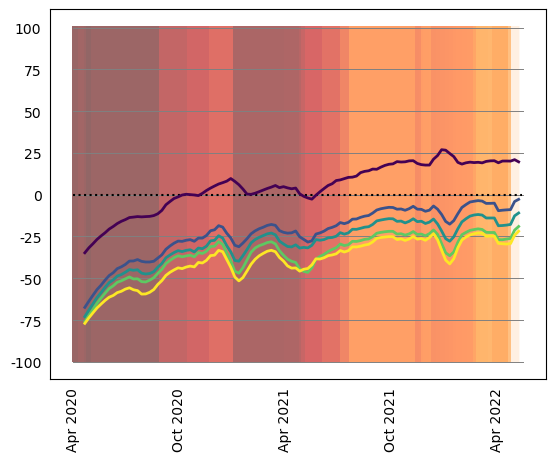

In [18]:
fig, ax = plt.subplots()

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

viridis = plt.cm.get_cmap('viridis')
norm = plt.Normalize(0, n_class_density-1)

for i in range(n_class_density):
    
    color = viridis(norm(i)) 
    df_ts_weekly_class_density_plot = pd.DataFrame({'perchange_class': df_ts_weekly_class_density[i, :]})
    df_ts_weekly_class_density_plot.loc[:,'rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].rolling(window=4).mean()
    ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=2, zorder=3)

ax.plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), np.zeros(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), linestyle=':', color='k')

stringencies = []
for date in df_ts['date']:
    stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

ymin = int(min([-100, np.min(df_ts_weekly_class_density)]))
ymax = int(max([101, np.max([i for i in df_ts_weekly_class_density.flatten() if i < np.max(df_ts_weekly_class_density)])+1]))

for k in range(len(df_ts)):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, ymin, ymax, color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)

xticks = []
xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
for i in range(0, len(df_ts['rolling_perchange'])):
    if i%183 == 0:
        xticks.append(i)
ax.set_xticks(xticks, xticks_labels)
ax.tick_params(axis = 'x', bottom=True, labelsize = 10, pad=6, rotation=90)
    
yticks = []
for i in range(ymin, ymax):
    if i%25 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([0, len(df_ts['rolling_perchange'])],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 10, pad=6, rotation=0)
    
# plt.savefig(wd + '/plots/evolution/' + flows + '/by-density/' + country_short + '/evo' + dist + raw + adjust + '.pdf', bbox_inches = 'tight')

plt.show()

not possible for this  777
not possible for this  777
not possible for this  777
not possible for this  777
not possible for this  777


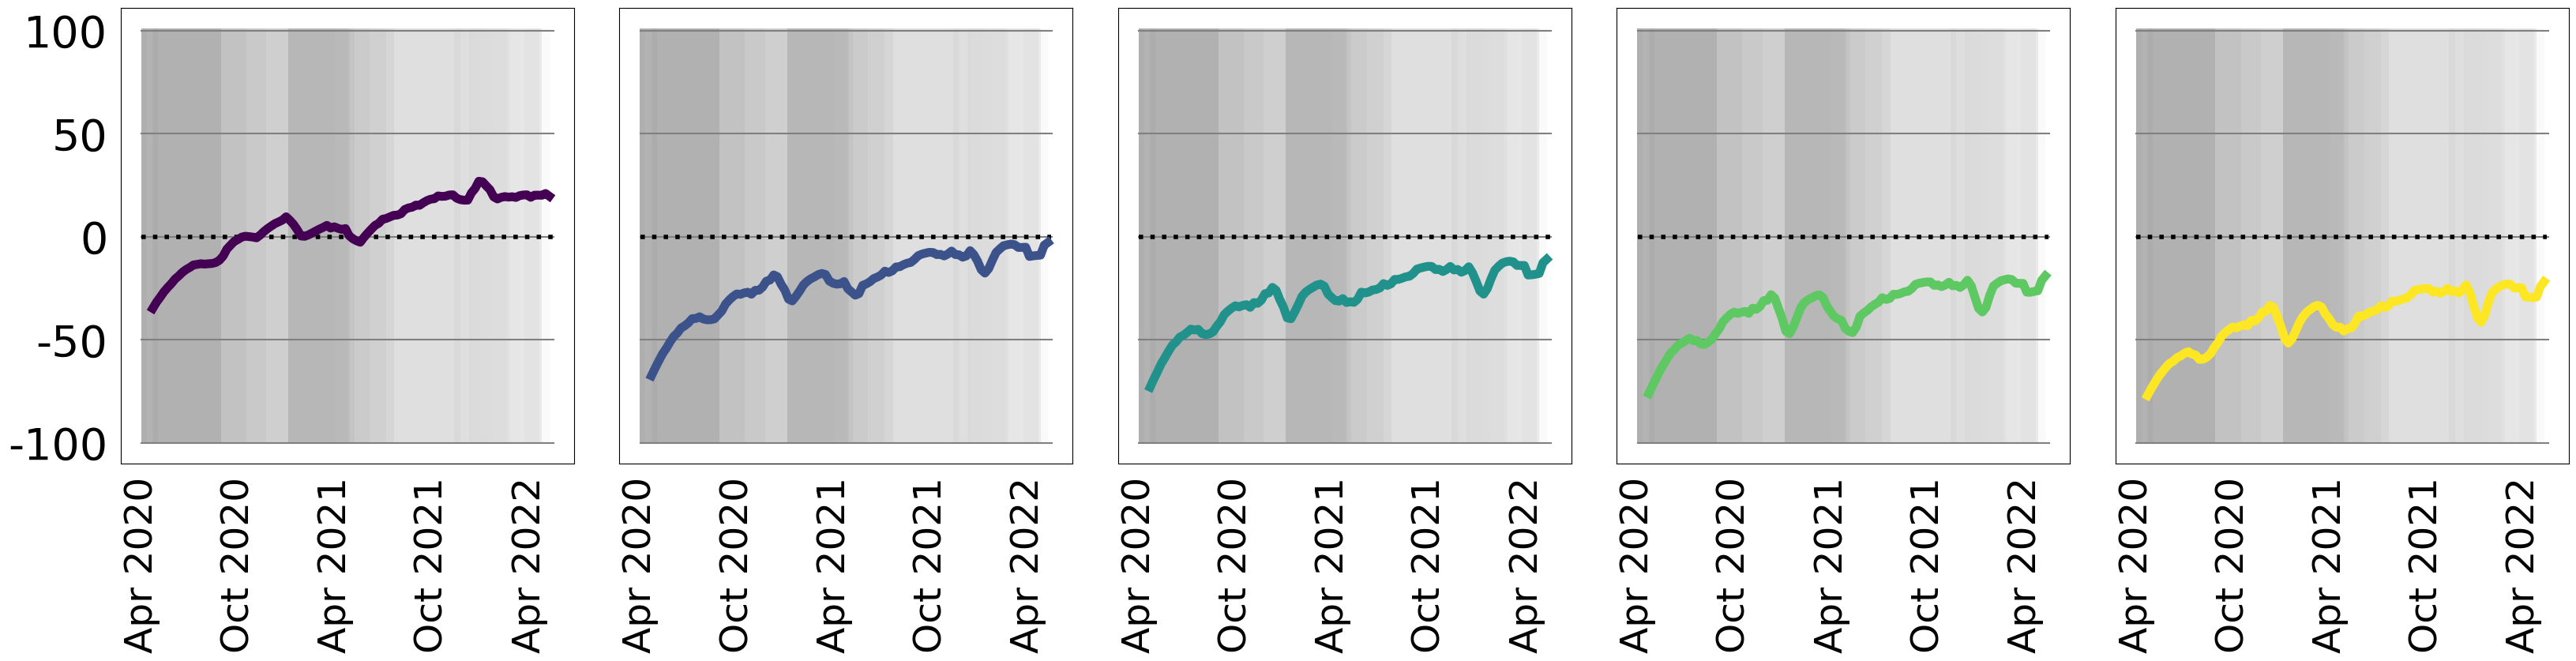

In [20]:
fig, axs = plt.subplots(1, n_class_density, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, figsize=(40,7.5))

for i in range(n_class_density):
    
    axs[i].tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

    viridis = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(0, n_class_density-1)

    color = viridis(norm(i)) 
    df_ts_weekly_class_density_plot = pd.DataFrame({'perchange_class': df_ts_weekly_class_density[i, :]})
    df_ts_weekly_class_density_plot.loc[:,'rolling_perchange'] = df_ts_weekly_class_density_plot['perchange_class'].rolling(window=4).mean()
    axs[i].plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange']))*7, df_ts_weekly_class_density_plot['rolling_perchange'], color=color, lw=8, zorder=6)

    axs[i].plot(np.arange(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), np.zeros(len(df_ts_weekly_class_density_plot['rolling_perchange'])*7), lw=4, linestyle=':', color='k', zorder=5)

    series = pd.DataFrame({'index': pd.to_datetime(df_ts_weekly['week_start']), 'value': df_ts_weekly_class_density[i,:]})
    series.index = series['index']
    series = series.drop(['index'], axis=1)
    try:
        result = seasonal_decompose(series, model='additive', extrapolate_trend='freq')
        df_trend.loc[k] = result.trend
#         axs[i,j].plot(np.arange(len(df_ts_weekly['week_start']))*7, result.trend, color='white', lw=2, linestyle='-', zorder=4)
    except:
        print('not possible for this ', k)
        
    stringencies = []
    for date in df_ts['date']:
        stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

    ymin = int(min([-100, np.min(df_ts_weekly_class_density)]))
    try:
        ymax = int(max([101, np.max([i for i in df_ts_weekly_class_density.flatten() if i < np.max(df_ts_weekly_class_density)])+1]))
    except:
        ymax = 101
        
    for l in range(len(df_ts)):
        try:
            rgba = matplotlib.cm.gray(1-(stringencies[l]-min(stringencies))/max(stringencies))
        except:
            rgba = matplotlib.cm.gray(1-(stringencies[l-1]-min(stringencies))/max(stringencies))
        x = [l-.50, l+.50]
        axs[i].fill_between(x, ymin, ymax, color=rgba, alpha=0.4, edgecolor='None', linewidth=0, zorder=0)

    xticks = []
    xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
    for l in range(0, len(df_ts['rolling_perchange'])):
        if l%183 == 0:
            xticks.append(l)
    axs[i].set_xticks(xticks, xticks_labels)
    axs[i].tick_params(axis = 'x', bottom=True, labelsize = 35, pad=12, rotation=90)

    yticks = []
    for l in range(ymin, ymax):
        if l%50 == 0:
            yticks.append(l)
    axs[i].set_yticks(yticks, yticks)
    for y in yticks:
        axs[i].plot([0, len(df_ts['rolling_perchange'])],[y,y], color='gray', lw=1.5, zorder=0)
    axs[i].tick_params(axis = 'y', labelsize = 40, pad=12, rotation=0)

plt.savefig(wd + '/plots/evolution/' + flows + '/by-density/' + country_short + '/evo' + dist + raw + adjust + '_by_origin.pdf', bbox_inches = 'tight')

plt.show()

### By rdi class

In [21]:
n_class_rdi = 3

breaks_rdi = jenkspy.jenks_breaks(baseline_pop_imput.dropna(subset=['rdi'])['rdi'], n_classes=n_class_rdi)
breaks_rdi[0] = breaks_rdi[0]-10**(-10)
# baseline_pop_imput['class_rdi'] = pd.qcut(baseline_pop_imput['rdi'], q=n_class_rdi, labels=[i for i in range(n_class_rdi)])
baseline_pop_imput['class_rdi'] = pd.cut(baseline_pop_imput['rdi'], bins=breaks_rdi, labels=[i for i in range(n_class_rdi)])
baseline_pop_imput['class_rdi'] = pd.to_numeric(baseline_pop_imput['class_rdi'])


In [22]:
class_rdi = np.unique(baseline_pop_imput['class_rdi'])
n_class_rdi = len(class_rdi[~np.isnan(class_rdi)])

In [23]:
df_ts_weekly_class_rdi = np.zeros((n_class_rdi, len(df_ts_weekly)))

for i in range(n_class_rdi):

    indexes = set(baseline_pop_imput[baseline_pop_imput['class_rdi']==i].index)
    if flows == 'movs':
        mask = df_flows['O'].isin(indexes) | df_flows['D'].isin(indexes)
    elif flows == 'outflows':
        mask = df_flows['O'].isin(indexes)
    elif flows == 'inflows':
        mask = df_flows['D'].isin(indexes)
    df_flows_class_rdi = df_flows[mask].reset_index(drop=True)
    df_flows_class_rdi_baseline = df_flows_baseline[mask].reset_index(drop=True)
    df_ts_class_rdi = compute_df_ts(df_flows_class_rdi, df_flows_class_rdi_baseline, initial_col)
    df_ts_weekly_class_rdi[i, :] = compute_df_ts_weekly(df_ts_class_rdi)['perchange']
    

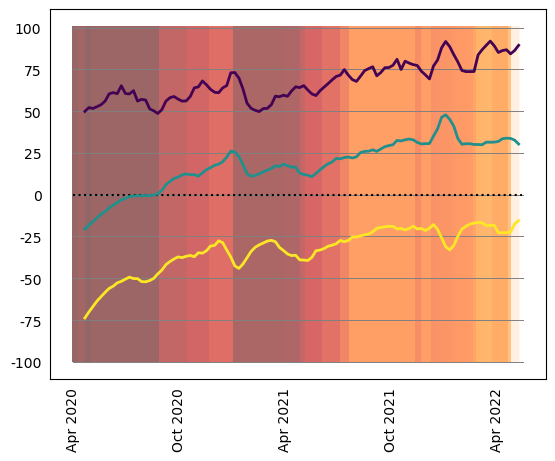

In [24]:
fig, ax = plt.subplots()

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

viridis = plt.cm.get_cmap('viridis_r')
norm = plt.Normalize(0, n_class_rdi-1)

for i in range(n_class_rdi):
    
    color = viridis(norm(i)) 
    df_ts_weekly_class_rdi_plot = pd.DataFrame({'perchange_class': df_ts_weekly_class_rdi[i, :]})
    df_ts_weekly_class_rdi_plot.loc[:,'rolling_perchange'] = df_ts_weekly_class_rdi_plot['perchange_class'].rolling(window=4).mean()
    ax.plot(np.arange(len(df_ts_weekly_class_rdi_plot['rolling_perchange']))*7, df_ts_weekly_class_rdi_plot['rolling_perchange'], color=color, lw=2, zorder=3)

ax.plot(np.arange(len(df_ts_weekly_class_rdi_plot['rolling_perchange'])*7), np.zeros(len(df_ts_weekly_class_rdi_plot['rolling_perchange'])*7), linestyle=':', color='k')

stringencies = []
for date in df_ts['date']:
    stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

ymin = int(min([-100, np.min(df_ts_weekly_class_rdi)]))
ymax = int(max([101, np.max([i for i in df_ts_weekly_class_density.flatten() if i < np.max(df_ts_weekly_class_density)])+1]))  
    
for k in range(len(df_ts)):
    try:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k]-min(stringencies))/max(stringencies))
    except:
        rgba = matplotlib.cm.gist_heat(1-(stringencies[k-1]-min(stringencies))/max(stringencies))
    x = [k-.50, k+.50]
    ax.fill_between(x, ymin, ymax, color=rgba, alpha=0.6, edgecolor='None', linewidth=0, zorder=0)

xticks = []
xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
for i in range(0, len(df_ts['rolling_perchange'])):
    if i%183 == 0:
        xticks.append(i)
ax.set_xticks(xticks, xticks_labels)
ax.tick_params(axis = 'x', bottom=True, labelsize = 10, pad=6, rotation=90)
    
yticks = []
for i in range(ymin, ymax):
    if i%25 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([0, len(df_ts['rolling_perchange'])],[y,y], color='gray', lw=0.7, zorder=0)
ax.tick_params(axis = 'y', labelsize = 10, pad=6, rotation=0)
    
# plt.savefig(wd + '/plots/evolution/' + flows + '/by-rdi/' + country_short + '/evo' + dist + raw + adjust + '.pdf', bbox_inches = 'tight')

plt.show()

not possible for this  777
not possible for this  777
not possible for this  777


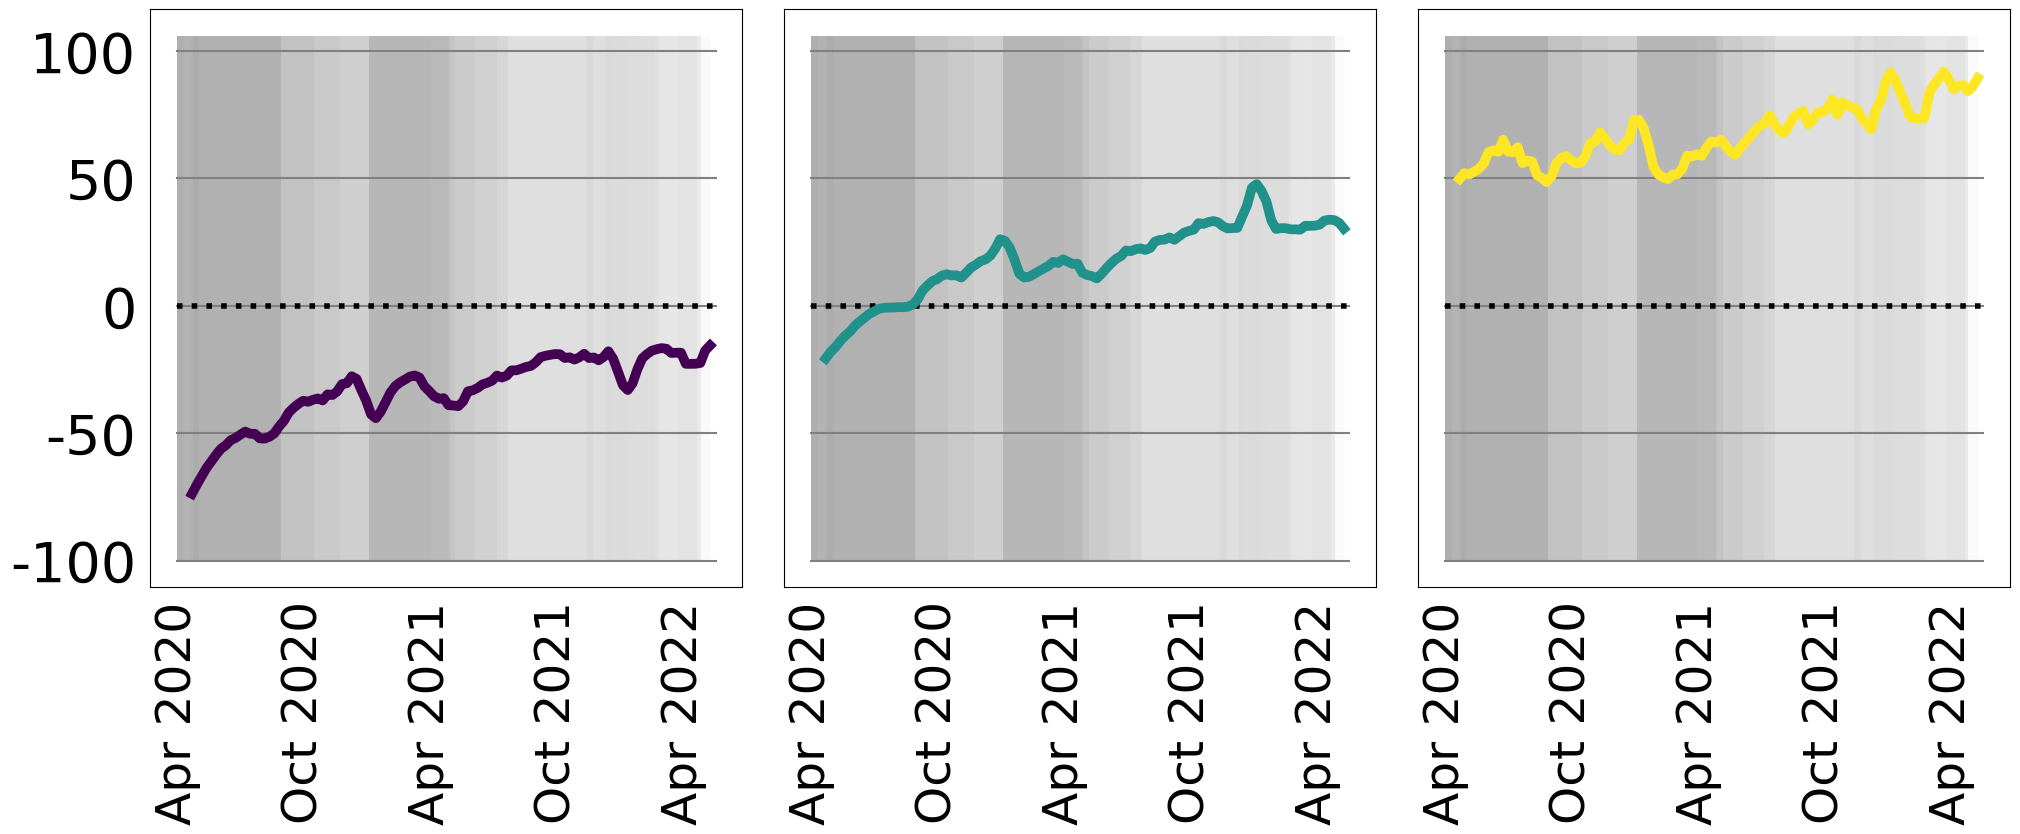

In [29]:
fig, axs = plt.subplots(1, n_class_rdi, sharey=True, gridspec_kw={'hspace': 0.07, 'wspace': 0.07}, figsize=(24,7.5))

for i in range(n_class_rdi):
    
    axs[i].tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

    viridis = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(0, n_class_rdi-1)

    color = viridis(norm(i)) 
    df_ts_weekly_class_rdi_plot = pd.DataFrame({'perchange_class': df_ts_weekly_class_rdi[i, :]})
    df_ts_weekly_class_rdi_plot.loc[:,'rolling_perchange'] = df_ts_weekly_class_rdi_plot['perchange_class'].rolling(window=4).mean()
    axs[i].plot(np.arange(len(df_ts_weekly_class_rdi_plot['rolling_perchange']))*7, df_ts_weekly_class_rdi_plot['rolling_perchange'], color=color, lw=7, zorder=6)

    axs[i].plot(np.arange(len(df_ts_weekly_class_rdi_plot['rolling_perchange'])*7), np.zeros(len(df_ts_weekly_class_rdi_plot['rolling_perchange'])*7), lw=4, linestyle=':', color='k', zorder=5)

    series = pd.DataFrame({'index': pd.to_datetime(df_ts_weekly['week_start']), 'value': df_ts_weekly_class_rdi[i,:]})
    series.index = series['index']
    series = series.drop(['index'], axis=1)
    try:
        result = seasonal_decompose(series, model='additive', extrapolate_trend='freq')
        df_trend.loc[k] = result.trend
#         axs[i,j].plot(np.arange(len(df_ts_weekly['week_start']))*7, result.trend, color='white', lw=2, linestyle='-', zorder=4)
    except:
        print('not possible for this ', k)
        
    stringencies = []
    for date in df_ts['date']:
        stringencies.append(df_stringency[df_stringency['date']==date].reset_index(drop=True).loc[0,'stringency_index'])

    ymin = int(min([-100, np.min(df_ts_weekly_class_rdi)]))
    try:
        ymax = int(max([101, np.max([i for i in df_ts_weekly_class_rdi.flatten() if i < np.max(df_ts_weekly_class_rdi)])+1]))
    except:
        ymax = 101
        
    for l in range(len(df_ts)):
        try:
            rgba = matplotlib.cm.gray(1-(stringencies[l]-min(stringencies))/max(stringencies))
        except:
            rgba = matplotlib.cm.gray(1-(stringencies[l-1]-min(stringencies))/max(stringencies))
        x = [l-.50, l+.50]
        axs[i].fill_between(x, ymin, ymax, color=rgba, alpha=0.4, edgecolor='None', linewidth=0, zorder=0)

    xticks = []
    xticks_labels = ['Apr 2020', 'Oct 2020', 'Apr 2021', 'Oct 2021', 'Apr 2022']
    for l in range(0, len(df_ts['rolling_perchange'])):
        if l%183 == 0:
            xticks.append(l)
    axs[i].set_xticks(xticks, xticks_labels)
    axs[i].tick_params(axis = 'x', bottom=True, labelsize = 35, pad=10, rotation=90)

    yticks = []
    for l in range(ymin, ymax):
        if l%50 == 0:
            yticks.append(l)
    axs[i].set_yticks(yticks, yticks)
    for y in yticks:
        axs[i].plot([0, len(df_ts['rolling_perchange'])],[y,y], color='gray', lw=1.5, zorder=0)
    axs[i].tick_params(axis = 'y', labelsize = 40, pad=10, rotation=0)

# plt.savefig(wd + '/plots/evolution/' + flows + '/by-rdi/' + country_short + '/evo' + dist + raw + adjust + '_by_origin.pdf', bbox_inches = 'tight')

plt.show()